In [1]:
!pip install tqdm
!pip install gensim

    100% |████████████████████████████████| 51kB 18.1MB/s 
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 24.2MB 2.1MB/s 
    100% |████████████████████████████████| 40kB 27.2MB/s 
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f7/a6/ff/9ab5842c14e50e95a06a4675b0b4a689c9cab6064dac2b01d0
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [4]:
pd.options.display.max_rows = 4000
pd.options.display.max_colwidth = 1000

In [5]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [6]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 150
EPOCHS = 16
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model_3.h5"
WORD2VEC_MODEL = "model_3.w2v"
TOKENIZER_MODEL = "tokenizer_3.pkl"
ENCODER_MODEL = "encoder_3.pkl"
HISTORY = "history_3.pkl"

In [7]:
df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [8]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 662 ms, sys: 1.4 ms, total: 664 ms
Wall time: 663 ms


Text(0.5,1,'Dataset labels distribuition')

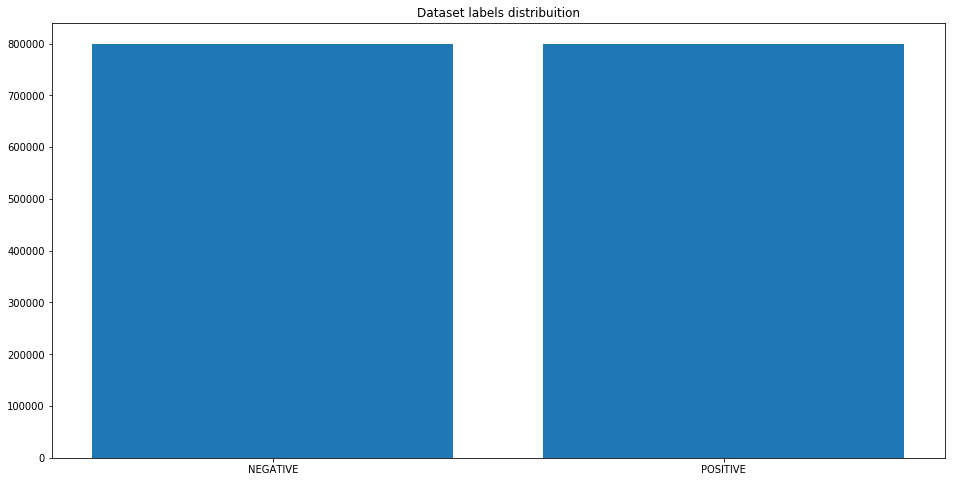

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=True):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 3min 40s, sys: 48.7 ms, total: 3min 40s
Wall time: 3min 40s


In [16]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [17]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.78 s, sys: 292 ms, total: 3.08 s
Wall time: 3.08 s


In [19]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            sg=1,
                                            workers=8)

In [20]:
w2v_model.build_vocab(documents)

2019-02-17 13:24:48,737 : INFO : collecting all words and their counts
2019-02-17 13:24:48,738 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-17 13:24:48,762 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 11479 word types
2019-02-17 13:24:48,782 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 17621 word types
2019-02-17 13:24:48,803 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 22443 word types
2019-02-17 13:24:48,823 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 26700 word types
2019-02-17 13:24:48,843 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 30663 word types
2019-02-17 13:24:48,864 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 34422 word types
2019-02-17 13:24:48,884 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 37906 word types
2019-02-17 13:24:48,904 : INFO : PROGRESS: at s

In [21]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 23654


In [22]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-02-17 13:24:56,911 : INFO : training model with 8 workers on 23654 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-02-17 13:24:57,928 : INFO : EPOCH 1 - PROGRESS: at 7.82% examples, 626089 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:24:58,940 : INFO : EPOCH 1 - PROGRESS: at 16.81% examples, 672758 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:25:00,007 : INFO : EPOCH 1 - PROGRESS: at 26.02% examples, 681916 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:25:01,010 : INFO : EPOCH 1 - PROGRESS: at 35.00% examples, 692548 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:25:02,011 : INFO : EPOCH 1 - PROGRESS: at 43.75% examples, 695864 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:25:03,018 : INFO : EPOCH 1 - PROGRESS: at 52.73% examples, 700402 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:25:04,082 : INFO : EPOCH 1 - PROGRESS: at 61.61% examples, 696889 words/s, in_qsize 15, out_qsize 0
2019-02-17 13:25:05,086 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 47min 30s, sys: 1.21 s, total: 47min 32s
Wall time: 6min 7s


(259094736, 295270528)

In [23]:
w2v_model.most_similar("obama")

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
2019-02-17 13:31:08,910 : INFO : precomputing L2-norms of word weight vectors


[('presid', 0.5678578615188599),
 ('barack', 0.4940849542617798),
 ('sadekhm', 0.45997464656829834),
 ('pres', 0.3764737844467163),
 ('prodcast', 0.37151777744293213),
 ('herebi', 0.34985655546188354),
 ('tiananmen', 0.33594560623168945),
 ('ahmadinejad', 0.3353745937347412),
 ('committe', 0.3312254548072815),
 ('correspond', 0.32944053411483765)]

In [24]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 248736
CPU times: user 21 s, sys: 43.9 ms, total: 21 s
Wall time: 21 s


In [25]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 32.1 s, sys: 1.33 s, total: 33.4 s
Wall time: 33.4 s


In [26]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [27]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [28]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 150)
y_train (1280000, 1)

x_test (320000, 150)
y_test (320000, 1)


In [29]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [30]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
print(x_train[22,:])

[    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0   151  1183   262   926   242 44799  3308   670   159   164   362]


In [31]:
df_train.iloc[[22]]

target         ids                          date      flag   user  \
1065132  POSITIVE  1964871940  Fri May 29 14:56:52 PDT 2009  NO_QUERY  Emity   

                                                                  text  
1065132  mayb five month nobodi die treatabl unlik flu guess mean care

In [32]:
tokenizer.word_index['maybe']

18202

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(248736, 300)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          74620800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 74,781,301
Trainable params: 160,501
Non-trainable params: 74,620,800
_________________________________________________________________


In [36]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=callbacks)
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)
pickle.dump(history, open(HISTORY, "wb"), protocol=0)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/16
1152000/1152000 [==============================] - 510s 443us/step - loss: 0.5287 - acc: 0.7321 - val_loss: 0.4763 - val_acc: 0.7702
Epoch 2/16
1152000/1152000 [==============================] - 505s 438us/step - loss: 0.4974 - acc: 0.7544 - val_loss: 0.4648 - val_acc: 0.7759
Epoch 3/16
1152000/1152000 [==============================] - 505s 438us/step - loss: 0.4875 - acc: 0.7615 - val_loss: 0.4588 - val_acc: 0.7815
Epoch 4/16
1152000/1152000 [==============================] - 505s 438us/step - loss: 0.4819 - acc: 0.7649 - val_loss: 0.4539 - val_acc: 0.7844
Epoch 5/16
1152000/1152000 [==============================] - 505s 438us/step - loss: 0.4783 - acc: 0.7678 - val_loss: 0.4511 - val_acc: 0.7863
Epoch 6/16
1152000/1152000 [==============================] - 505s 438us/step - loss: 0.4754 - acc: 0.7695 - val_loss: 0.4495 - val_acc: 0.7871
Epoch 7/16
1152000/1152000 [==============================] - 505s 438us/step - los

In [45]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 54s 170us/step

ACCURACY: 0.79118125
LOSS: 0.4420118254184723
CPU times: user 47.2 s, sys: 4.47 s, total: 51.7 s
Wall time: 54.4 s


In [ ]:
model.save(KERAS_MODEL)

In [ ]:
w2v_model.save(WORD2VEC_MODEL)


In [ ]:
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)

In [ ]:
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [ ]:
pickle.dump(history, open(HISTORY, "wb"), protocol=0)

In [46]:
history.history

{'val_loss': [0.47626955080032346,
  0.4647658007144928,
  0.45884673452377317,
  0.45389489936828614,
  0.45111094093322757,
  0.44951650786399844,
  0.4481949579715729,
  0.4463067319393158,
  0.44580269885063173,
  0.4450250358581543,
  0.4441256766319275,
  0.4433367531299591,
  0.44300583815574646,
  0.44332348155975343,
  0.4430477521419525,
  0.44289870047569274],
 'val_acc': [0.77015625,
  0.7758515625,
  0.7815390625,
  0.7843984375,
  0.786265625,
  0.7871328125,
  0.787515625,
  0.7893984375,
  0.789734375,
  0.790234375,
  0.7903671875,
  0.7910625,
  0.7909453125,
  0.79121875,
  0.7905859375,
  0.7909921875],
 'loss': [0.5286932504442003,
  0.49741159465577867,
  0.4874914083480835,
  0.48188388771480983,
  0.47828975134425694,
  0.47537428773774043,
  0.4731195975674523,
  0.471764535135693,
  0.4699532495074802,
  0.46907498378223844,
  0.46742999291419984,
  0.4668423273563385,
  0.46591455748346117,
  0.46539577433798046,
  0.4643348910543654,
  0.46385751795768737],


In [47]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('history.json', 'w'))

TypeError: Object of type 'float32' is not JSON serializable